In [1]:
import sys
import os
import itertools
import numpy as np
import torch as tr
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')
import pprint

import multiprocessing as mp
import concurrent
import time
tstamp = time.perf_counter_ns()

from utils import *

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


# build timeout
- timeout
    - previous experiments contained only valid trials
    - timeout makes the task more challenging by making rewards more sparse
        - reward function is same: on final step of trial, correct action `reward=1`, 0 otherwise
        - timeout: if `action={1,2}` on hold timesteps, next trial is `invalid`
        - invalid trials: no stimuli, zero filled delay. 

- PWM5:
    - 5 stimuli (ABCDE) 
    - A&E are edge cases where response given by second stim
    - others require comparison
    
    
### approach:
- start with 3 trials of len 3 each 
- middle trial is either valid or invalid depending on whether violated first trial

In [2]:
def seed_exp(seed,args):
  """ loss [(value, policy),neps] """
  # setup
  np.random.seed(seed)
  neps = args['train']['neps']
  # task and agent definition
  agent = ActorCritic(**args['agent'])
  task = PWMTaskFR(**args['task'])
  # init loop vars
  reward = -np.ones(neps)
  loss = -np.ones([2,neps])
  pism = -np.ones([3,neps])
  trcount = -np.ones(neps)
  L = []
  # loop over epochs
  for epoch in range(neps):
    epoch_data = run_epoch_FR(agent,task)
    epoch_data = process_epdata(epoch_data)
    update_data = agent.update(epoch_data)
    trcount[epoch] = np.sum(epoch_data['ttype'])
    reward[epoch] = np.sum(epoch_data['reward'])/task.ntrials
    loss[:,epoch] = list(update_data.values())
  data = {'loss':loss,'reward':reward,'trcount':trcount}
  return data

In [3]:
# common setup
ns,neps = 3,50000
args = {
  'train':{
    'neps':neps
  },
  'agent':{
    'gamma':1.0,
    'learnrate':0.005,
    'lweight':None # gridsearching
  },
  'task':{
    'stimset':'pwm5',
    'epoch_len':9, ## 3 trials len 3 each
    'trlen':3
  }
}
# loop vars
lwL = [0.5,1,2,3]
loss = np.zeros([len(lwL),ns,2,neps])
reward = np.zeros([len(lwL),ns,neps])
trcount = np.zeros([len(lwL),ns,neps])
# gridsearch loss weight
for idx in range(len(lwL)):
  print(idx)
  # setup and run exp
  args['agent']['lweight'] = lwL[idx]
  dataL = exp_mp(seed_exp,nseeds=ns,gsvar=args)
  # unpack data
  loss[idx] = np.array([d['loss'] for d in dataL])
  reward[idx] = np.array([d['reward'] for d in dataL])
  trcount[idx] = np.array([d['trcount'] for d in dataL])

# reshape data for plotting
vloss = loss[:,:,0,:]
ploss = loss[:,:,1,:]
data = np.array([reward,vloss,ploss])
data.shape # [{R/vL/pL},cond,seeds,epochs]

0
1
2
3


(3, 4, 3, 50000)

### plots

(0.0, 1.0)

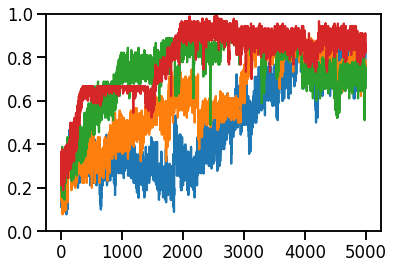

In [4]:
# reward
for r in reward.mean(1):
  plt.plot(r.reshape(-1,10).mean(-1))
plt.ylim(0,1)

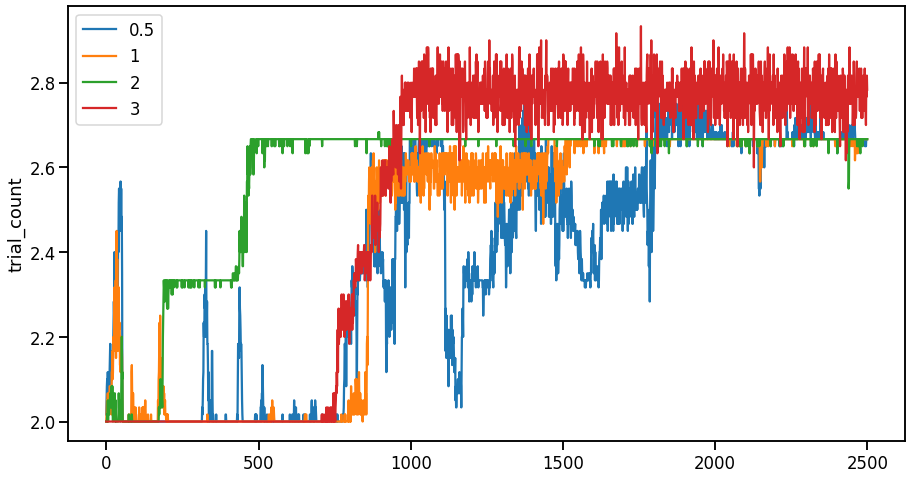

In [5]:
plt.figure(figsize=(15,8))
# trial count
for idx in range(len(lwL)): # loop over conds
  plt.plot(trcount[idx].mean(0).reshape(-1,20).mean(-1),
          label=lwL[idx])
plt.ylabel('trial_count')
plt.legend()
plt.savefig('figures/trial_count-pwm5eplen%i-REINFORCE-lrate_%.4f-%iseeds-gridsearch_lossweight-%i.png'%(
  args['task']['epoch_len'],args['agent']['learnrate'],ns,tstamp)
)

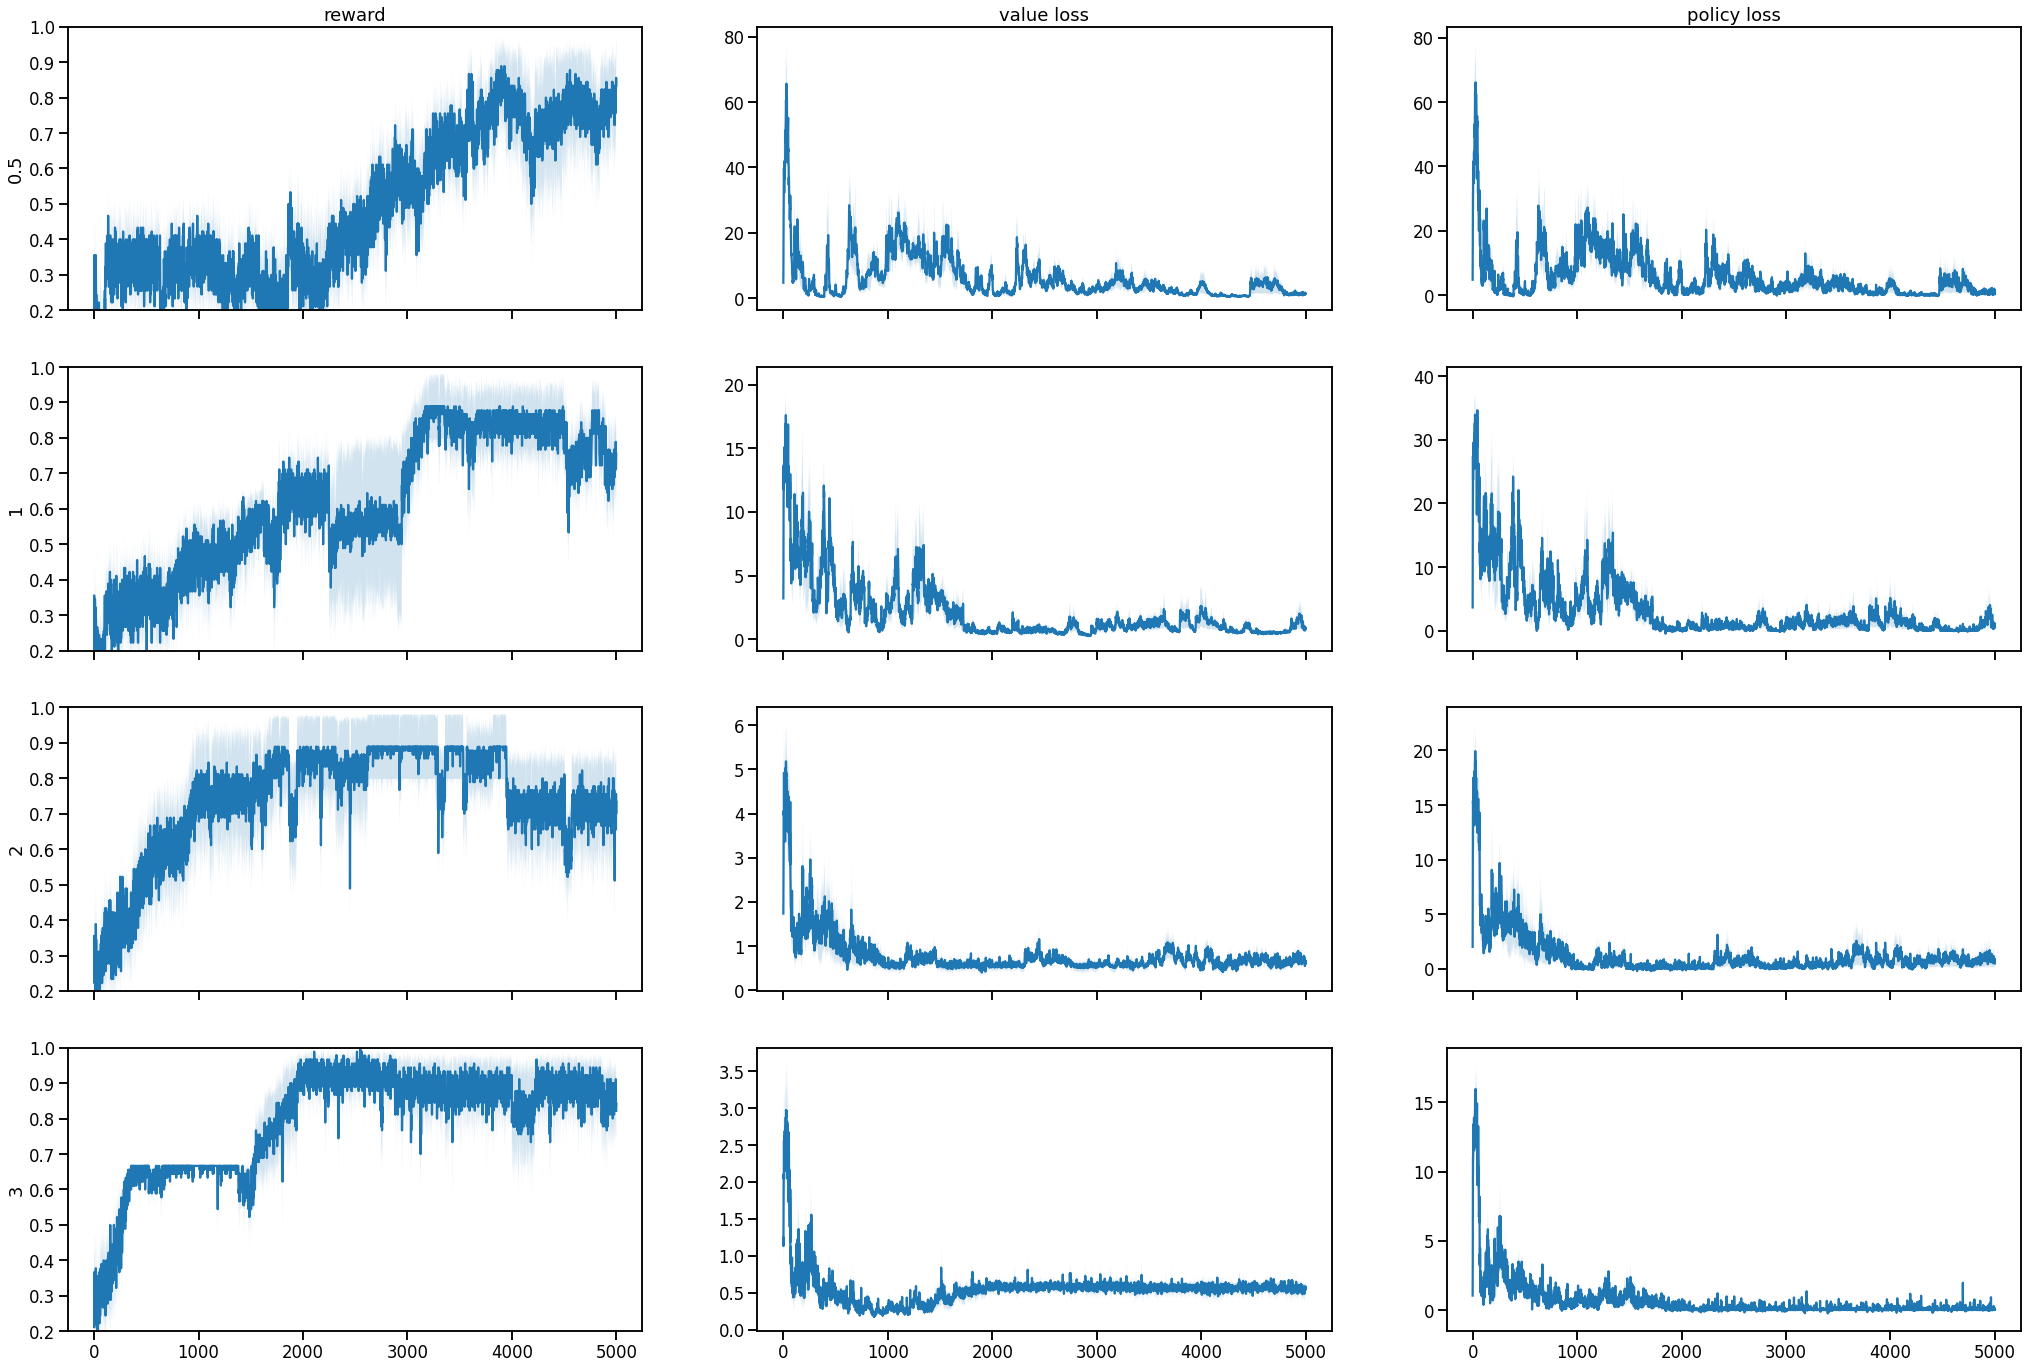

In [6]:
def plt_metrics(data,condL,mawin=10):
  """ plot data{reward,vloss,ploss}
  input shapes [num_cond,seed,epochs]
  moving average to smooth plots
  condL labels conds along num_cond
  """
  _,ncond,nseeds,nepochs = data.shape
  mdata = data.mean(2)
  sdata = data.std(2)/np.sqrt(nseeds)
  # plot setup
  f,axar = plt.subplots(ncond,3,figsize=(35,6*ncond),sharex=True)
  axar[0,0].set_title('reward')
  axar[0,1].set_title('value loss')
  axar[0,2].set_title('policy loss')
  # loop over axes
  for ci in range(ncond):
    axa = axar[ci]
    axa[0].set_ylabel(condL[ci])
    axa[0].set_ylim(0.2,1)
    for ii in range(3):
      ax = axa[ii]
      # moving average
      M = mdata[ii,ci].reshape(-1,mawin).mean(-1)
      S = sdata[ii,ci].reshape(-1,mawin).mean(-1)
      ax.plot(M)
      ax.fill_between(range(len(M)),M-S,M+S,alpha=0.2)

  return None

plt_metrics(data,lwL,mawin=10)

plt.savefig('figures/loss+reward-pwm5eplen%i-REINFORCE-lrate_%.4f-%iseeds-gridsearch_lossweight-%i.png'%(
  args['task']['epoch_len'],args['agent']['learnrate'],ns,tstamp)
)